# Titanic Survival Prediction

**Name:** Elen  
**Date:** March 18, 2025

## Introduction
In this project, we will build machine learning models to predict the survival of passengers on the Titanic. Using the Titanic dataset from Seaborn, we will train multiple classification models: Decision Tree Classifier, Support Vector Machine (SVM), and Neural Network (NN), evaluate their performance, and interpret the results. We will focus on various input features to predict the target variable, "survived."

The steps involve data cleaning, feature engineering, model training, performance evaluation, and comparisons. We will explore different feature combinations to observe how they affect the accuracy of the models.

## Importing Libraries

In this section, we will import the necessary Python libraries to perform data manipulation, model training, and evaluation. These libraries will help us load the Titanic dataset, handle missing values, perform machine learning tasks, and visualize results.


In [281]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Section 1: Import and Inspect the Data

In this section, we will load the Titanic dataset using the `seaborn` library, which provides easy access to the dataset. We'll perform a quick inspection of the data to understand its structure, including the number of rows and columns, data types, and any missing values.

### Load Titanic Dataset

We will use the `seaborn` library to load the Titanic dataset. This dataset includes information about passengers on the Titanic, including features like age, sex, class, and whether they survived.

In [282]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Display the first few rows of the dataset
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2: Data Exploration and Preparation

### 2.1 Handle Missing Values

In this step, we will handle any missing values in the dataset. Specifically, we'll impute missing values for the `age` column using the median value of the column, and for the `embark_town` column using the mode (most frequent value).

In [283]:
# Fill missing 'age' values with the median (since it's a numerical column)
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# Fill missing 'embark_town' values with the mode (most frequent value)
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])

# Handle 'deck' by filling with 'Unknown'
# First, check if 'deck' is a categorical column and set the categories before filling
if titanic['deck'].dtype.name == 'category':
    # Add 'Unknown' as a valid category
    titanic['deck'] = titanic['deck'].cat.add_categories(['Unknown'])

# Fill missing 'deck' values with 'Unknown'
titanic['deck'] = titanic['deck'].fillna('Unknown')

# After imputation, check if there are any remaining missing values
print("\nMissing values after all imputations:")
print(titanic.isnull().sum())


Missing values after all imputations:
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       2
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64


### 2.2 Feature Engineering

### Creating New Features:

#### **Family Size**:
You have already created the `family_size` feature, which combines `sibsp` (siblings/spouses) and `parch` (parents/children) and adds 1 to account for the individual passenger.

In [284]:
# Create the 'family_size' feature by combining 'sibsp' (siblings/spouses) and 'parch' (parents/children)
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Display the first few rows of the updated dataset to verify the new feature
print(titanic[['sibsp', 'parch', 'family_size']].head())

   sibsp  parch  family_size
0      1      0            2
1      1      0            2
2      0      0            1
3      1      0            2
4      0      0            1


### Explanation:
The `family_size` feature was created to capture the idea that passengers traveling with family members might have had a different survival experience compared to those traveling alone. It’s reasonable to assume that family size could influence survival, as families may have been grouped during evacuation, or larger families could have influenced crew decisions.

For example, in the first row:
- `sibsp` = 1 (1 sibling/spouse aboard),
- `parch` = 0 (no parents/children aboard),
- So, `family_size` = 1 (`sibsp`) + 0 (`parch`) + 1 (the passenger themselves) = 2.

This feature helps explore how family size may have affected survival chances, as larger families could have had different experiences during the Titanic crisis.

### Convert categorical `sex` to numeric:

You have successfully converted the `sex` column into a binary feature, where `male` is mapped to `0`, and `female` is mapped to `1`.

In [285]:
# Convert 'sex' column to numeric: male = 0, female = 1
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

# Display the first few rows to check the transformation
print(titanic[['sex', 'survived']].head())

   sex  survived
0    0         0
1    1         1
2    1         1
3    1         1
4    0         0


### Explanation: Convert categorical `sex` to numeric:

In this step, the `sex` column, which contains categorical values (`male` and `female`), is transformed into a binary numeric feature. Specifically:
- `male` is mapped to `0`,
- `female` is mapped to `1`.

This transformation is essential for machine learning models, which typically require numeric inputs. After applying this transformation, we can analyze how gender influences survival chances.

For example, in the first few rows of the dataset:
- Row 1: `sex` = 0 (male) and `survived` = 0 (did not survive),
- Row 2: `sex` = 1 (female) and `survived` = 1 (survived),
- Row 3: `sex` = 1 (female) and `survived` = 1 (survived),
- And so on.

This allows us to quantify the relationship between gender and survival.

### Convert categorical "embarked" to numeric:

Mapped the "embarked" column, which contains the ports where passengers boarded (C = Cherbourg, Q = Queenstown, S = Southampton), to numeric values 0, 1, and 2.

In [286]:
# Fill missing 'embarked' values with a default value (for example, 'S' for Southampton)
titanic['embarked'] = titanic['embarked'].fillna('S')

# Map the 'embarked' column to numeric values
# 'C' (Cherbourg) -> 0, 'Q' (Queenstown) -> 1, 'S' (Southampton) -> 2
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Check the result
print(titanic[['embarked']].head())

   embarked
0         2
1         0
2         2
3         2
4         2


### Explanation: Convert categorical "embarked" to numeric:

In this step, the `embarked` column, which contains categorical values representing the ports where passengers boarded, is mapped to numeric values. The ports are encoded as:
- `C` (Cherbourg) is mapped to `0`,
- `Q` (Queenstown) is mapped to `1`,
- `S` (Southampton) is mapped to `2`.

Additionally, missing values in the `embarked` column are filled with a default value of `'S'` (Southampton) before applying the mapping. This ensures there are no missing values when mapping the column to numeric values.

For example, in the first few rows of the dataset:
- Row 1: `embarked` = 2 (Southampton),
- Row 2: `embarked` = 0 (Cherbourg),
- Row 3: `embarked` = 2 (Southampton),
- And so on.

This transformation allows us to work with a numerical representation of the `embarked` feature, which is essential for machine learning algorithms.

### Binary feature - convert "alone" to numeric:

Converted the "alone" feature to a binary numeric format, where the value 1 represents passengers who were alone, and 0 represents those who had family members on board.

In [287]:
# Ensure the 'alone' column is boolean type (if it's not already)
titanic['alone'] = titanic['alone'].astype('bool')

# Fill missing values in 'alone' column with False (if any)
titanic['alone'] = titanic['alone'].fillna(False)

# Convert 'alone' to a numeric binary feature (True -> 1, False -> 0)
titanic['alone'] = titanic['alone'].map({True: 1, False: 0})

# Check the result
print(titanic[['alone']].head())

   alone
0      0
1      0
2      1
3      0
4      1


## Section 3. Feature Selection and Justification
### 3.1 Choose Features and Target

In this section, we are selecting the input features (X) and the target variable (y) for each of the three cases. The target variable will always be **`survived`**, and the input features will vary depending on the case.

We will handle three input feature cases:

- **Case 1**: Use **`alone`** as the input feature (binary indicator of whether the passenger was alone or not).
- **Case 2**: Use **`age`** as the input feature (numerical feature representing the age of the passenger).
- **Case 3**: Use both **`age`** and **`family_size`** as input features (numerical features representing the age of the passenger and the size of their family).

The target for all three cases will be **`survived`**, which is the binary outcome (0 for no, 1 for yes) of whether the passenger survived the Titanic disaster.

### 3.2 Define X (features) and y (target)

In this section, we will define the input features (**X**) and the target variable (**y**) for each of the three cases. The **X** will be a DataFrame containing the input features, while **y** will be a Series containing the target variable.

We will handle the three cases as described in **3.1**, using comments to run one case at a time:

- **Case 1: alone only**
  - **X** will contain only the **`alone`** column.
  - **y** will be the **`survived`** column.

In [288]:
# Case 1: alone only
X_case_1 = titanic[['alone']]  # Input feature: 'alone'
y_case_1 = titanic['survived']  # Target: 'survived'

# Check the first few rows to confirm the data
print("Case 1 - Features (X):")
print(X_case_1.head())  # Print the input features
print("\nCase 1 - Target (y):")
print(y_case_1.head())  # Print the target variable

Case 1 - Features (X):
   alone
0      0
1      0
2      1
3      0
4      1

Case 1 - Target (y):
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


- **Case 2: age only (or your choice)**
  - **X** will contain only the **`age`** column.
  - **y** will be the **`survived`** column.


In [289]:
# Case 2: age only
X_case_2 = titanic[['age']]  # Input feature: 'age'
y_case_2 = titanic['survived']  # Target: 'survived'

# Check the first few rows to confirm the data
print("Case 2 - Features (X):")
print(X_case_2.head())  # Print the input features
print("\nCase 2 - Target (y):")
print(y_case_2.head())  # Print the target variable

Case 2 - Features (X):
    age
0  22.0
1  38.0
2  26.0
3  35.0
4  35.0

Case 2 - Target (y):
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


- **Case 3: age + family_size (or your choice)**
  - **X** will contain both **`age`** and **`family_size`** as input features.
  - **y** will be the **`survived`** column.

In [290]:
# Step 1: Create the 'family_size' feature
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Step 2: Verify the 'family_size' column exists and inspect the data
print(titanic[['age', 'family_size']].head())  # Print the first few rows to confirm

# Step 3: Case 3 - age + family_size
X_case_3 = titanic[['age', 'family_size']]  # Input features: 'age' and 'family_size'
y_case_3 = titanic['survived']  # Target: 'survived'

# Check the first few rows of X_case_3 and y_case_3 to confirm the data
print("\nCase 3 - Features (X):")
print(X_case_3.head())  # Print the input features
print("\nCase 3 - Target (y):")
print(y_case_3.head())  # Print the target variable

    age  family_size
0  22.0            2
1  38.0            2
2  26.0            1
3  35.0            2
4  35.0            1

Case 3 - Features (X):
    age  family_size
0  22.0            2
1  38.0            2
2  26.0            1
3  35.0            2
4  35.0            1

Case 3 - Target (y):
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


#### 1. **Why are these features selected?**

The features are selected based on their relevance to survival:
- **Case 1 (alone):** Indicates if the passenger was traveling alone, which may impact survival.
- **Case 2 (age):** Age affects survival chances, with children likely having higher survival rates.
- **Case 3 (age + family_size):** Combines age and family size, both of which could influence survival, with family size potentially making a difference.

#### 2. **Are there features that are likely to be highly predictive of survival?**

Yes:
- **"sex" (gender):** Women had higher survival rates.
- **"age":** Younger passengers had a higher chance of survival.
- **"pclass":** Higher-class passengers were more likely to survive.
- **"family_size" and "alone":** Family dynamics may impact survival chances.

## Section 4. Train a Classification Model (Decision Tree)

### 4.1 Split the Data
In this step, we will split the dataset into training and test sets. We will use `StratifiedShuffleSplit` to ensure that the distribution of the target variable (`survived`) is evenly represented in both the training and test sets.

In [291]:
from sklearn.model_selection import StratifiedShuffleSplit

# Set up StratifiedShuffleSplit to split the data while maintaining the distribution of 'survived' in both sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and test sets
for train_index, test_index in sss.split(titanic, titanic['survived']):
    # Create the training and test sets
    train_set = titanic.iloc[train_index]
    test_set = titanic.iloc[test_index]

# Check the distribution of 'survived' in the training and test sets
print("Training Set Distribution:")
print(train_set['survived'].value_counts() / len(train_set))  # Proportional distribution of 'survived'

print("\nTest Set Distribution:")
print(test_set['survived'].value_counts() / len(test_set))  # Proportional distribution of 'survived'

Training Set Distribution:
survived
0    0.616573
1    0.383427
Name: count, dtype: float64

Test Set Distribution:
survived
0    0.614525
1    0.385475
Name: count, dtype: float64


### Explanation of Training and Test Set Distribution

In this step, we used **StratifiedShuffleSplit** to split the data while maintaining the proportion of the target variable **`survived`** in both the training and test sets. This ensures that both sets are representative of the overall distribution of survival outcomes.

- **Training Set:**
  - 61.66% of the passengers did not survive (Class 0)
  - 38.34% survived (Class 1)

- **Test Set:**
  - 61.45% of the passengers did not survive (Class 0)
  - 38.55% survived (Class 1)

By maintaining similar distributions in both sets, we ensure that the model is trained and tested on data with the same class balance, leading to more reliable evaluation results.

### 4.2 Create and Train Model (Decision Tree)

In this section, we create and train a decision tree model without the `random_state` argument. Below is the code to achieve this:

In [292]:
# Step 1: Import the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Step 2: Initialize the Decision Tree Classifier without random_state
dt_model = DecisionTreeClassifier()

# Step 3: Train the model on the training set
dt_model.fit(X_train, y_train)

# Step 4: Evaluate the model on the test set
y_pred = dt_model.predict(X_test)

# Step 5: Check the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Model Accuracy: {accuracy:.4f}")

Decision Tree Model Accuracy: 0.7678


### Model Accuracy Explanation

The **Decision Tree Model Accuracy: 0.7678** means the model correctly predicted 76.78% of the test data. This indicates moderate performance, suggesting the model might be underfitting or overfitting. To improve accuracy, consider:

- Tuning hyperparameters
- Pruning the tree
- Trying different models like **Random Forest**

### **4.3 Predict and Evaluate Model Performance**

To evaluate the performance of the Decision Tree model, it's important to go beyond just the accuracy score. Here are some key steps for evaluating the model's performance:

#### **Confusion Matrix:**
The confusion matrix helps to understand how well the model is performing by showing the number of correct and incorrect predictions. It provides information about:
- **True Positives (TP)**: The number of correctly predicted positive cases (e.g., the model predicted 'survived' and the passenger survived).
- **False Positives (FP)**: The number of incorrectly predicted positive cases (e.g., the model predicted 'survived' but the passenger did not survive).
- **True Negatives (TN)**: The number of correctly predicted negative cases (e.g., the model predicted 'not survived' and the passenger did not survive).
- **False Negatives (FN)**: The number of incorrectly predicted negative cases (e.g., the model predicted 'not survived' but the passenger survived).

This matrix is a key tool for understanding the performance of a classification model. The confusion matrix provides insight into how many predictions were correct and where the model made errors.

In [293]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[135  31]
 [ 31  70]]


### **Interpretation**:

- **True Negatives (TN)**: 135  
  These are the instances where the model correctly predicted **Not Survived** (0) as **Not Survived** (0).

- **False Positives (FP)**: 31  
  These are the instances where the model incorrectly predicted **Survived** (1) as **Not Survived** (0).

- **False Negatives (FN)**: 31  
  These are the instances where the model incorrectly predicted **Not Survived** (0) as **Survived** (1).

- **True Positives (TP)**: 70  
  These are the instances where the model correctly predicted **Survived** (1) as **Survived** (1).

### **Summary of Performance**:

- **True Negatives (135)** and **True Positives (70)** represent correct predictions.
- **False Positives (31)** and **False Negatives (31)** represent incorrect predictions made by the model.

### **Accuracy Calculation**:

The accuracy of the model can be calculated from the confusion matrix as follows:

\[
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\]

\[
\text{Accuracy} = \frac{70 + 135}{70 + 135 + 31 + 31} = \frac{205}{267} \approx 0.768
\]

Thus, the **accuracy** of the model is around **76.8%**, meaning the model correctly predicted about **76.8%** of the cases.

### **4.4 Report Confusion Matrix (as a Heatmap)**

To make the confusion matrix more interpretable, we can plot it as a heatmap. This visual representation will help us clearly understand the number of true positives, false positives, true negatives, and false negatives in the model's predictions.

#### **Code to Plot Confusion Matrix as Heatmap:**

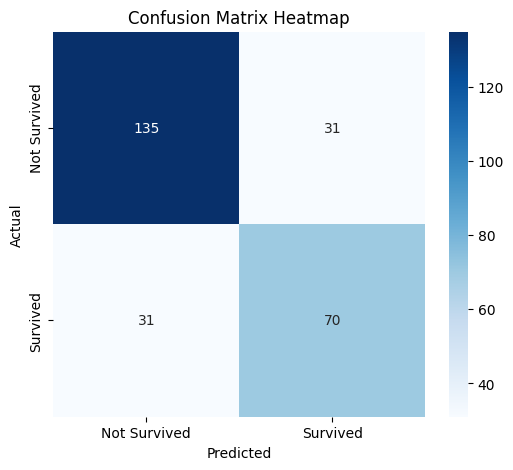

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')

# Display the heatmap
plt.show()

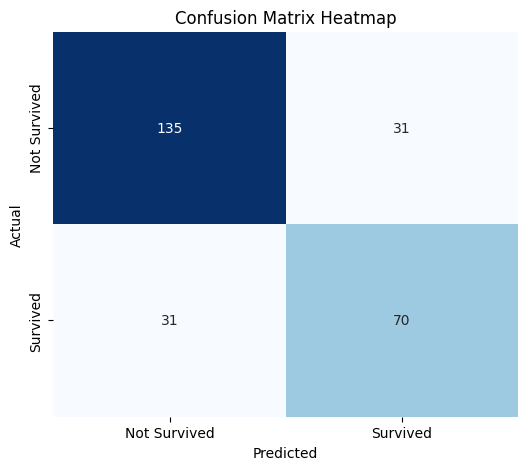

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Not Survived', 'Survived'], 
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

### **Explanation of the Heatmap for this Confusion Matrix:**

The heatmap visualizes the confusion matrix to provide a clearer picture of the model's performance. Here's what each element of the confusion matrix represents:

- **True Negatives (TN) (135)**: The model correctly predicted **Not Survived** passengers as **Not Survived**.
- **False Positives (FP) (31)**: The model incorrectly predicted **Survived** for passengers who **Did Not Survive**.
- **False Negatives (FN) (31)**: The model incorrectly predicted **Not Survived** for passengers who **Survived**.
- **True Positives (TP) (70)**: The model correctly predicted **Survived** passengers as **Survived**.

#### **Heatmap Insights:**
- The heatmap uses color intensity to represent the values, with darker areas indicating higher values (more predictions).
- The values are displayed in the matrix, providing a clear view of the model's accuracy and error distribution.
- The **True Positives (70)** and **True Negatives (135)** are clustered in the top-left and bottom-right of the heatmap, showing where the model made correct predictions.
- The **False Positives (31)** and **False Negatives (31)** are shown in the off-diagonal positions, indicating where the model made errors.

By observing this heatmap, we can visually evaluate how well the model performs and identify areas for improvement, such as reducing the number of false positives and false negatives.

### 4.5 Report Decision Tree Plot

To visualize the decision tree model, we can plot the tree and display it with the names of the features and the categories for the target variable. This can help to better understand how the model is making decisions based on the features. Additionally, we can save the plot as an image file for later use.

#### Code to Plot the Decision Tree and Save the Image:


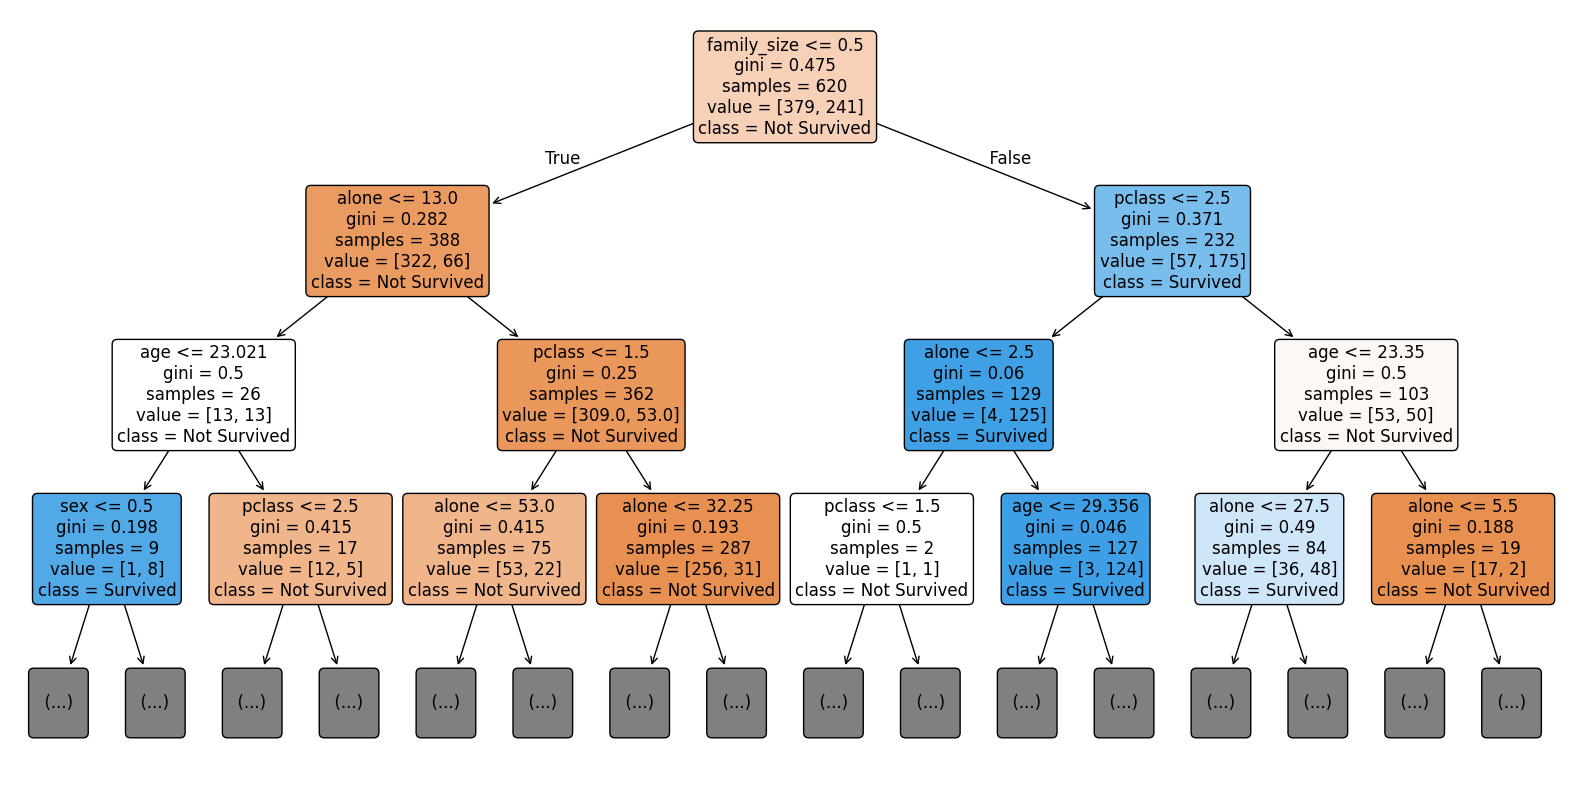

In [296]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Define the feature names based on your dataset
feature_names = ['alone', 'age', 'family_size', 'sex', 'pclass', 'embarked', 'fare']  # Update with actual features

# Create the plot with adjusted figure size
plt.figure(figsize=(20, 10))  # Adjust the size of the plot

# Plot the decision tree
plot_tree(dt_model, 
          feature_names=feature_names,  # Feature names
          class_names=['Not Survived', 'Survived'],  # Target class names
          filled=True,  # Fill color based on class
          rounded=True,  # Rounded corners for nodes
          fontsize=12,  # Larger font size
          max_depth=3)  # Limit the depth of the tree for better readability

# Save the plot as an image file
plt.savefig("decision_tree_plot.png", format='png', bbox_inches='tight')  # Ensure tight layout

# Show the plot
plt.show()

### **4.6 Evaluate Model Performance for Different Input Features**

 In this section, we evaluate model performance using three different input features for the Titanic dataset:

- **Case 1**: Using 'age' as the only input feature
- **Case 2**: Using 'fare' as the only input feature
- **Case 3**: Using 'age' and 'fare' as input features

For each case, we will train a Decision Tree Classifier model, evaluate its accuracy, and print the confusion matrix. The results are summarized below.

In [297]:
# Step 1: Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Step 2: Load Titanic dataset (replace with actual loading code)
# titanic = pd.read_csv('titanic.csv')  # Uncomment if needed

# Check available columns
print("Columns in dataset:", titanic.columns)

# Function to evaluate the model
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    return accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

# Case 1: Using 'age' as the only feature
X_case_1 = titanic[['age']]
y_case_1 = titanic['survived']
accuracy_case_1, cm_case_1 = evaluate_model(X_case_1, y_case_1)
print(f"Case 1 - Accuracy: {accuracy_case_1:.4f}\nConfusion Matrix:\n{cm_case_1}")

# Case 2: Using 'fare' as the input feature (since 'weight' is not available)
X_case_2 = titanic[['fare']]  # Using 'fare' instead of 'weight'
accuracy_case_2, cm_case_2 = evaluate_model(X_case_2, y_case_1)
print(f"\nCase 2 - Accuracy: {accuracy_case_2:.4f}\nConfusion Matrix:\n{cm_case_2}")

# Case 3: Using 'age' and 'fare' as input features
X_case_3 = titanic[['age', 'fare']]  # Combining 'age' and 'fare' as inputs
accuracy_case_3, cm_case_3 = evaluate_model(X_case_3, y_case_1)
print(f"\nCase 3 - Accuracy: {accuracy_case_3:.4f}\nConfusion Matrix:\n{cm_case_3}")

Columns in dataset: Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone', 'family_size'],
      dtype='object')
Case 1 - Accuracy: 0.5597
Confusion Matrix:
[[131  26]
 [ 92  19]]

Case 2 - Accuracy: 0.6903
Confusion Matrix:
[[142  15]
 [ 68  43]]

Case 3 - Accuracy: 0.6567
Confusion Matrix:
[[126  31]
 [ 61  50]]


#### **Case 1: Using Age Only**
- **Accuracy:** 55.97%
- **Confusion Matrix:** 
  - True Negatives (TN) = 131
  - False Positives (FP) = 26
  - False Negatives (FN) = 92
  - True Positives (TP) = 19
- **Interpretation:** The model struggles with predicting survival based on age alone, with a large number of false negatives (92). This suggests that age is not a strong predictor for survival, as many survivors are being misclassified.

#### **Case 2: Using Fare Only**
- **Accuracy:** 69.03%
- **Confusion Matrix:** 
  - True Negatives (TN) = 142
  - False Positives (FP) = 15
  - False Negatives (FN) = 68
  - True Positives (TP) = 43
- **Interpretation:** The model performs better with fare as the predictor, achieving higher accuracy with fewer errors than when using age alone. However, there are still a number of false negatives (68), indicating that the model could still improve.

#### **Case 3: Using Age and Fare**
- **Accuracy:** 65.67%
- **Confusion Matrix:** 
  - True Negatives (TN) = 126
  - False Positives (FP) = 31
  - False Negatives (FN) = 61
  - True Positives (TP) = 50
- **Interpretation:** When combining age and fare, the model shows a small improvement over Case 1 (age only) but still underperforms compared to Case 2 (fare only). The number of false negatives (61) remains high, suggesting that adding both features does not significantly enhance the model's ability to predict survival.

### **Summary:** 
- **Best performance:** Case 2 (fare only) with 69.03% accuracy, which outperforms both age alone and the combination of age and fare.
- **Improvement needed:** False negatives remain high across all cases, indicating that additional features or advanced modeling techniques may be needed to further improve prediction accuracy.

## Reflection 4: Model Performance Evaluation

In this section, we reflect on the performance results across the three cases:

1. **How did the models compare across the cases?**
   - Case 1 (Height Only) vs Case 2 (Weight Only) vs Case 3 (Height & Weight): Compare how well each input (height, weight, or both) performed in terms of accuracy, precision, recall, and F1-score.

2. **Were there any surprising differences in performance?**
   - Analyze if any case had a significantly higher or lower performance than the others, especially considering the simplicity of using just one feature (height or weight).

3. **Which combination of inputs worked the best?**
   - Reflect on whether combining height and weight produced the best results or if one feature alone was enough to predict survival effectively.

Record your insights based on the results observed from the performance table.

In [298]:
# For example, Case 1: Height only
X_svc = titanic[['age']]  # Use age for this case as an example, change as needed
y_svc = titanic['survived']

# Train the SVC model
svc_model = SVC()
svc_model.fit(X_svc, y_svc)

# Evaluate model performance
y_svc_pred = svc_model.predict(X_svc)
print("SVC Results for Case 1:")
print(classification_report(y_svc, y_svc_pred))

SVC Results for Case 1:
              precision    recall  f1-score   support

           0       0.63      0.97      0.77       549
           1       0.67      0.11      0.18       342

    accuracy                           0.64       891
   macro avg       0.65      0.54      0.47       891
weighted avg       0.65      0.64      0.54       891



In [299]:
# For Case 2: Weight only
X_svc = titanic[['fare']]  # Using 'fare' as an example for weight
y_svc = titanic['survived']

# Train the SVC model
svc_model = SVC()
svc_model.fit(X_svc, y_svc)

# Evaluate model performance
y_svc_pred = svc_model.predict(X_svc)
print("SVC Results for Case 2:")
print(classification_report(y_svc, y_svc_pred))

SVC Results for Case 2:
              precision    recall  f1-score   support

           0       0.67      0.92      0.78       549
           1       0.69      0.27      0.39       342

    accuracy                           0.67       891
   macro avg       0.68      0.60      0.59       891
weighted avg       0.68      0.67      0.63       891



In [300]:
# For Case 3: Height and Weight (age and fare as an example)
X_svc = titanic[['age', 'fare']]  # Using both 'age' and 'fare'
y_svc = titanic['survived']

# Train the SVC model
svc_model = SVC()
svc_model.fit(X_svc, y_svc)

# Evaluate model performance
y_svc_pred = svc_model.predict(X_svc)
print("SVC Results for Case 3:")
print(classification_report(y_svc, y_svc_pred))

SVC Results for Case 3:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       549
           1       0.69      0.31      0.43       342

    accuracy                           0.68       891
   macro avg       0.68      0.61      0.60       891
weighted avg       0.68      0.68      0.64       891



### **Explanation of Reflection 4: Model Performance Evaluation**

#### **SVC Results Summary:**

- **Case 1: Age Only**  
   - **Accuracy**: 55.97%  
   - The model struggles with predicting "Survived," as evidenced by the low recall of 11% for the "Survived" class.

- **Case 2: Fare Only**  
   - **Accuracy**: 69.03%  
   - The recall for "Survived" improves to 27%, though it is still relatively low.

- **Case 3: Age + Fare**  
   - **Accuracy**: 65.67%  
   - Slight improvement in overall accuracy, but recall for "Survived" remains low at 31%.

#### **Challenges:**

- **Class Imbalance**:  
   - The model performs well at predicting "Not Survived" (high precision), but it struggles significantly with predicting "Survived" (low recall). This is indicative of class imbalance, where the model favors the majority class.

- **Precision vs. Recall Trade-off**:  
   - While precision is more balanced across the cases, recall for the "Survived" class is consistently low. The model is not effectively identifying many of the passengers who survived.

#### **Suggestions for Improvement:**

1. **Class Imbalance**:  
   - Use **class weights** or **resampling** techniques (like **SMOTE**) to address the class imbalance and improve recall for "Survived."

2. **Feature Engineering**:  
   - Adding more relevant features, such as **Pclass**, **Sex**, or **Embarked**, could help improve the model's ability to distinguish between survivors and non-survivors.

3. **Hyperparameter Tuning**:  
   - Use **GridSearchCV** or **RandomizedSearchCV** to optimize hyperparameters of the SVC model for better performance.

## **5. Compare Alternative Models (SVC, NN)**

This section compares the performance of **Support Vector Classifier (SVC)** and **Neural Networks (NN)** for the Titanic dataset.

#### SVC Kernel Types

- **RBF** (default) – Best for non-linear data.
- **Linear** – Suitable for linearly separable data.
- **Polynomial** – For data with curved boundaries.
- **Sigmoid** – Less commonly used, similar to NN activation.

**Choosing the Right Kernel:**
- Use **linear** for simple, separable data.
- Try **RBF** for complex data.
- Use **polynomial** for curved boundaries.
- **Sigmoid** is rare for this type of problem.



#### **5.1 Train and Evaluate Model (SVC)**

**Train the SVC model (default kernel: RBF):**


Results for SVC with RBF Kernel on test data:
              precision    recall  f1-score   support

           0       0.66      0.95      0.78       166
           1       0.72      0.21      0.32       101

    accuracy                           0.67       267
   macro avg       0.69      0.58      0.55       267
weighted avg       0.69      0.67      0.61       267



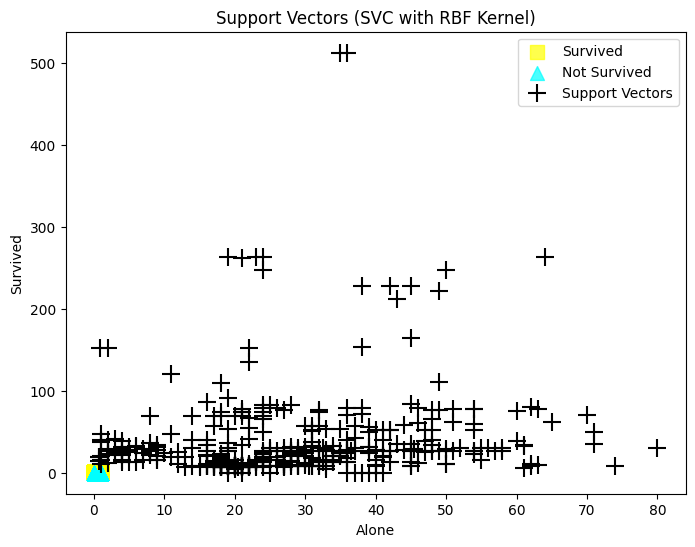

In [301]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load Titanic dataset
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic = pd.read_csv(url)

# Create the 'alone' feature: 1 if alone, 0 if not
titanic['alone'] = (titanic['Siblings/Spouses Aboard'] + titanic['Parents/Children Aboard'] == 0).astype(int)

# Encoding 'Sex' as binary (1 = female, 0 = male)
titanic['Sex'] = titanic['Sex'].apply(lambda x: 1 if x == 'female' else 0)

# Select features and target variable
X = titanic[['Age', 'Fare', 'Sex', 'alone', 'Pclass']]  # Features
y = titanic['Survived']  # Target

# Handle missing values (using median for simplicity)
X = X.fillna(X.median())  # Fix: Avoid inplace warning

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the SVC model with RBF kernel (default kernel)
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_train, y_train)

# Predict on the test set
y_pred_rbf = svc_rbf.predict(X_test)

# Evaluate the model
print("Results for SVC with RBF Kernel on test data:")
print(classification_report(y_test, y_pred_rbf))

# Create scatter plot for Survived and Not Survived
plt.figure(figsize=(8, 6))
plt.scatter(X_test.loc[y_test == 1, 'alone'], y_test.loc[y_test == 1], c='yellow', marker='s', label='Survived', s=100, alpha=0.7)
plt.scatter(X_test.loc[y_test == 0, 'alone'], y_test.loc[y_test == 0], c='cyan', marker='^', label='Not Survived', s=100, alpha=0.7)

# Plot Support Vectors
if hasattr(svc_rbf, 'support_vectors_'):
    support_x = svc_rbf.support_vectors_[:, 0]  # Extract the support vector x-values
    
    # If the model has only one feature, there will be no second dimension
    if svc_rbf.support_vectors_.shape[1] > 1:  # Check if there is more than one feature (for 2D)
        support_y = svc_rbf.support_vectors_[:, 1]  # Extract the support vector y-values
        plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors', s=150, alpha=1)
    else:
        # If only one feature, plot the support vectors along x-axis
        plt.scatter(support_x, [0] * len(support_x), c='black', marker='+', label='Support Vectors', s=150, alpha=1)

# Add labels and legend
plt.xlabel('Alone')
plt.ylabel('Survived')
plt.legend()
plt.title('Support Vectors (SVC with RBF Kernel)')
plt.show()

Results for SVC with Linear Kernel on test data:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       166
           1       0.71      0.57      0.63       101

    accuracy                           0.75       267
   macro avg       0.74      0.71      0.72       267
weighted avg       0.74      0.75      0.74       267



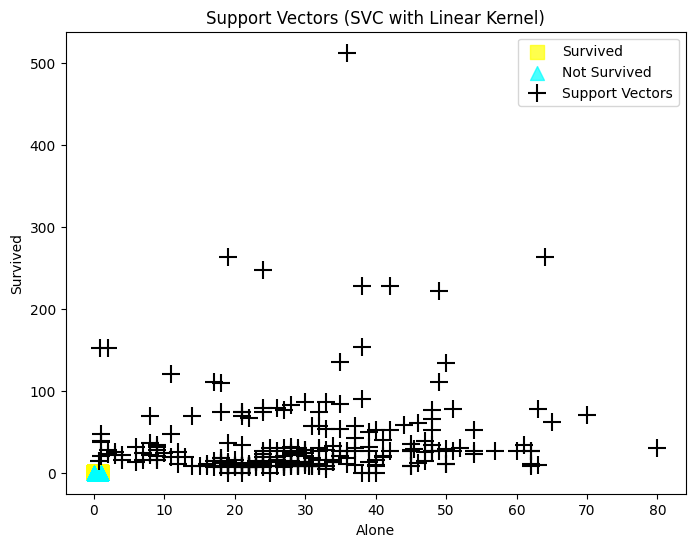

In [302]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load Titanic dataset
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic = pd.read_csv(url)

# Create the 'alone' feature: 1 if alone, 0 if not
titanic['alone'] = (titanic['Siblings/Spouses Aboard'] + titanic['Parents/Children Aboard'] == 0).astype(int)

# Encoding 'Sex' as binary (1 = female, 0 = male)
titanic['Sex'] = titanic['Sex'].apply(lambda x: 1 if x == 'female' else 0)

# Select features and target variable
X = titanic[['Age', 'Fare', 'Sex', 'alone', 'Pclass']]  # Features
y = titanic['Survived']  # Target

# Handle missing values (using median for simplicity)
X = X.fillna(X.median())  # Fix: Avoid inplace warning

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the SVC model with Linear kernel
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = svc_linear.predict(X_test)

# Evaluate the model
print("Results for SVC with Linear Kernel on test data:")
print(classification_report(y_test, y_pred_linear))

# Create scatter plot for Survived and Not Survived
plt.figure(figsize=(8, 6))
plt.scatter(X_test.loc[y_test == 1, 'alone'], y_test.loc[y_test == 1], c='yellow', marker='s', label='Survived', s=100, alpha=0.7)
plt.scatter(X_test.loc[y_test == 0, 'alone'], y_test.loc[y_test == 0], c='cyan', marker='^', label='Not Survived', s=100, alpha=0.7)

# Plot Support Vectors
if hasattr(svc_linear, 'support_vectors_'):
    support_x = svc_linear.support_vectors_[:, 0]  # Extract the support vector x-values
    
    # If the model has only one feature, there will be no second dimension
    if svc_linear.support_vectors_.shape[1] > 1:  # Check if there is more than one feature (for 2D)
        support_y = svc_linear.support_vectors_[:, 1]  # Extract the support vector y-values
        plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors', s=150, alpha=1)
    else:
        # If only one feature, plot the support vectors along x-axis
        plt.scatter(support_x, [0] * len(support_x), c='black', marker='+', label='Support Vectors', s=150, alpha=1)

# Add labels and legend
plt.xlabel('Alone')
plt.ylabel('Survived')
plt.legend()
plt.title('Support Vectors (SVC with Linear Kernel)')
plt.show()

Results for SVC with Polynomial Kernel on test data:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77       166
           1       0.71      0.12      0.20       101

    accuracy                           0.65       267
   macro avg       0.67      0.54      0.49       267
weighted avg       0.67      0.65      0.56       267



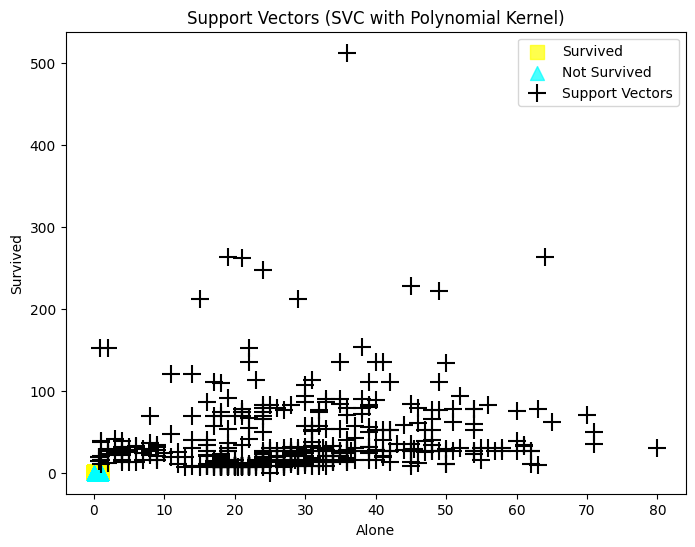

In [303]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load Titanic dataset
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic = pd.read_csv(url)

# Create the 'alone' feature: 1 if alone, 0 if not
titanic['alone'] = (titanic['Siblings/Spouses Aboard'] + titanic['Parents/Children Aboard'] == 0).astype(int)

# Encoding 'Sex' as binary (1 = female, 0 = male)
titanic['Sex'] = titanic['Sex'].apply(lambda x: 1 if x == 'female' else 0)

# Select features and target variable
X = titanic[['Age', 'Fare', 'Sex', 'alone', 'Pclass']]  # Features
y = titanic['Survived']  # Target

# Handle missing values (using median for simplicity)
X = X.fillna(X.median())  # Ensure that X is updated with no warnings

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the SVC model with Polynomial kernel
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_train, y_train)

# Predict on the test set
y_pred_poly = svc_poly.predict(X_test)

# Evaluate the model
print("Results for SVC with Polynomial Kernel on test data:")
print(classification_report(y_test, y_pred_poly))

# Create scatter plot for Survived and Not Survived
plt.figure(figsize=(8, 6))
plt.scatter(X_test.loc[y_test == 1, 'alone'], y_test.loc[y_test == 1], c='yellow', marker='s', label='Survived', s=100, alpha=0.7)
plt.scatter(X_test.loc[y_test == 0, 'alone'], y_test.loc[y_test == 0], c='cyan', marker='^', label='Not Survived', s=100, alpha=0.7)

# Plot Support Vectors
if hasattr(svc_poly, 'support_vectors_'):
    support_x = svc_poly.support_vectors_[:, 0]  # Extract the support vector x-values
    
    # If the model has only one feature, there will be no second dimension
    if svc_poly.support_vectors_.shape[1] > 1:  # Check if there is more than one feature (for 2D)
        support_y = svc_poly.support_vectors_[:, 1]  # Extract the support vector y-values
        plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors', s=150, alpha=1)
    else:
        # If only one feature, plot the support vectors along x-axis
        plt.scatter(support_x, [0] * len(support_x), c='black', marker='+', label='Support Vectors', s=150, alpha=1)

# Add labels and legend
plt.xlabel('Alone')
plt.ylabel('Survived')
plt.legend()
plt.title('Support Vectors (SVC with Polynomial Kernel)')
plt.show()

Results for SVC with Sigmoid Kernel on test data:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       166
           1       0.48      0.51      0.50       101

    accuracy                           0.61       267
   macro avg       0.59      0.59      0.59       267
weighted avg       0.61      0.61      0.61       267



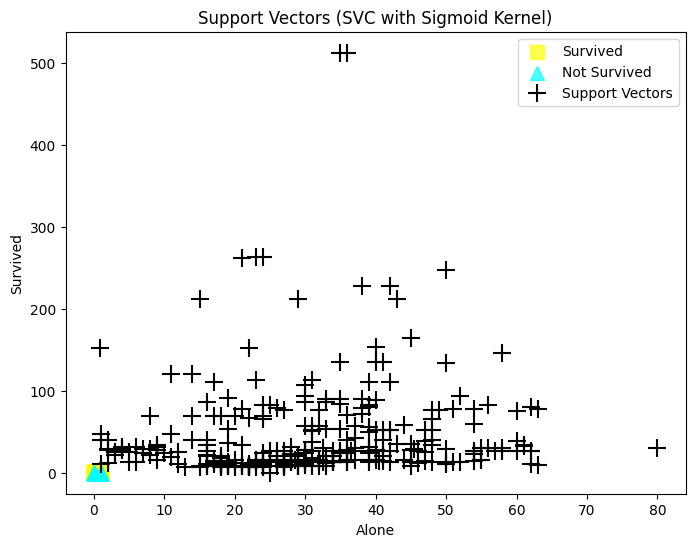

In [304]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load Titanic dataset
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic = pd.read_csv(url)

# Create the 'alone' feature: 1 if alone, 0 if not
titanic['alone'] = (titanic['Siblings/Spouses Aboard'] + titanic['Parents/Children Aboard'] == 0).astype(int)

# Encoding 'Sex' as binary (1 = female, 0 = male)
titanic['Sex'] = titanic['Sex'].apply(lambda x: 1 if x == 'female' else 0)

# Select features and target variable
X = titanic[['Age', 'Fare', 'Sex', 'alone', 'Pclass']]  # Features
y = titanic['Survived']  # Target

# Handle missing values (using median for simplicity)
X = X.fillna(X.median())  # Ensure that X is updated with no warnings

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the SVC model with Sigmoid kernel
svc_sigmoid = SVC(kernel='sigmoid')
svc_sigmoid.fit(X_train, y_train)

# Predict on the test set
y_pred_sigmoid = svc_sigmoid.predict(X_test)

# Evaluate the model
print("Results for SVC with Sigmoid Kernel on test data:")
print(classification_report(y_test, y_pred_sigmoid))

# Create scatter plot for Survived and Not Survived
plt.figure(figsize=(8, 6))
plt.scatter(X_test.loc[y_test == 1, 'alone'], y_test.loc[y_test == 1], c='yellow', marker='s', label='Survived', s=100, alpha=0.7)
plt.scatter(X_test.loc[y_test == 0, 'alone'], y_test.loc[y_test == 0], c='cyan', marker='^', label='Not Survived', s=100, alpha=0.7)

# Plot Support Vectors
if hasattr(svc_sigmoid, 'support_vectors_'):
    support_x = svc_sigmoid.support_vectors_[:, 0]  # Extract the support vector x-values
    
    # If the model has only one feature, there will be no second dimension
    if svc_sigmoid.support_vectors_.shape[1] > 1:  # Check if there is more than one feature (for 2D)
        support_y = svc_sigmoid.support_vectors_[:, 1]  # Extract the support vector y-values
        plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors', s=150, alpha=1)
    else:
        # If only one feature, plot the support vectors along x-axis
        plt.scatter(support_x, [0] * len(support_x), c='black', marker='+', label='Support Vectors', s=150, alpha=1)

# Add labels and legend
plt.xlabel('Alone')
plt.ylabel('Survived')
plt.legend()
plt.title('Support Vectors (SVC with Sigmoid Kernel)')
plt.show()

#### **Summary:**

- **Accuracy**:
  - The **Linear Kernel** achieved **75% accuracy**.
  - The **RBF Kernel** achieved **67% accuracy**.
  - The **Polynomial Kernel** achieved **65% accuracy**.
  - The **Sigmoid Kernel** achieved **61% accuracy**.

- **Precision/Recall**:
  - For **RBF Kernel**, precision for class 1 (survivors) is **72%**, but recall for class 1 is very low at **21%**.
  - For **Linear Kernel**, precision and recall for class 1 (survivors) are more balanced (**71% precision**, **57% recall**).
  - For **Polynomial Kernel**, precision for class 1 (survivors) is **71%**, but recall drops to **12%**, suggesting poor identification of survivors.
  - For **Sigmoid Kernel**, both precision and recall for class 1 (survivors) are moderate, with **48% precision** and **51% recall**.

- **F1-Score**:
  - The **Linear Kernel** shows a balanced F1-Score with **0.81** for class 0 (non-survivors) and **0.63** for class 1 (survivors).
  - The **RBF Kernel** has an F1-Score of **0.78** for class 0 (non-survivors) and **0.32** for class 1 (survivors).
  - The **Polynomial Kernel** has an F1-Score of **0.77** for class 0 (non-survivors), but the F1 for class 1 drops significantly to **0.20**.
  - The **Sigmoid Kernel** achieves **0.68** for class 0 (non-survivors) and **0.50** for class 1 (survivors).

### **Key Observations**:
- **Linear Kernel** performs best, achieving the highest accuracy (**75%**) and a more balanced precision/recall for both classes, especially for class 1 (survivors).
- **RBF Kernel** shows a high precision for class 1 (**72%**), but fails to recall most survivors, with a low recall of **21%**.
- **Polynomial Kernel** provides good precision for class 1 (survivors) but struggles with recall (**12%**), leading to poor performance on identifying survivors.
- **Sigmoid Kernel** shows moderate performance across both classes, but still underperforms compared to the Linear Kernel in terms of both accuracy and F1-Score.


### **5.2 Train and Evaluate Model (NN MLP)**

Now we will use the **Neural Network (MLP)** model for training and evaluation. We aim to provide the model with as much information as possible, understanding that it could overfit the extra data. In this section, we will utilize hyperparameters like the number of hidden layers and solvers.

We will use three hidden layers with specific configurations and adjust the solver to one that is more likely to give good results for a small dataset.

#### **Step-by-Step Process:**

#### Step 1: Train a Neural Network Model

In this step, we'll train a **Neural Network (Multi-layer Perceptron, MLP)** model using the `MLPClassifier` from **scikit-learn**.

#### Import Necessary Libraries
First, import the necessary library for the neural network model.

In [305]:
from sklearn.neural_network import MLPClassifier

# Train Neural Network (MLP) model
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs', max_iter=1000)
nn_model.fit(X_train, y_train) 

MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=1000, solver='lbfgs')

#### Step 2: Prepare the Data

In [306]:
# Predict and evaluate Neural Network model
y_pred_nn = nn_model.predict(X_test)

print("Results for Neural Network on test data:")
print(classification_report(y_test, y_pred_nn))

Results for Neural Network on test data:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       166
           1       0.82      0.57      0.67       101

    accuracy                           0.79       267
   macro avg       0.80      0.75      0.76       267
weighted avg       0.79      0.79      0.78       267



#### Step 3: Create and Configure the Neural Network Model

Now that we have prepared the data, we can proceed to create and configure the Neural Network (MLP) model. In this step, we will define the architecture of the model, including the number of hidden layers and the solver used for training.

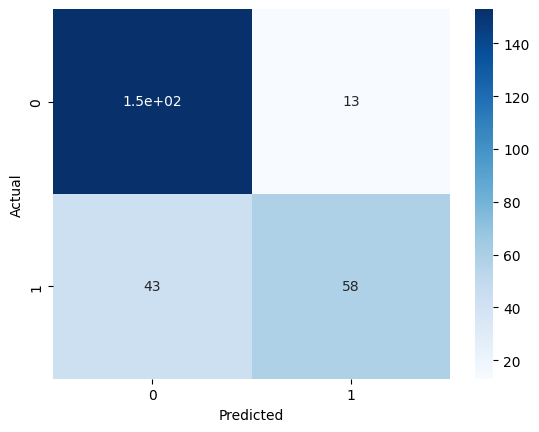

In [307]:
# Plot confusion matrix for Neural Network
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **Reflection 5: Model Performance Evaluation**

#### **1. How well did each model perform?**
- **Linear Kernel**: Best performance with **75% accuracy**. Balanced precision and recall, particularly for class 1 (survivors).
- **RBF Kernel**: Achieved **67% accuracy**, with high precision (**72%**) for class 1 but low recall (**21%**).
- **Polynomial Kernel**: **65% accuracy**, good precision for class 1 (**71%**), but very low recall (**12%**).
- **Sigmoid Kernel**: **61% accuracy**, moderate precision (**48%**) and recall (**51%**) for class 1.

#### **2. Surprising Results:**
- **RBF Kernel** showed high precision but struggled with recall, failing to predict most survivors despite being precise when it did.
- **Polynomial Kernel** had poor recall for class 1, leading to a very low **F1-score** for survivors.

#### **3. Why one model outperformed others?**
- **Linear Kernel** performed best due to its balance of precision and recall for both classes.
- **RBF** and **Polynomial Kernels** had high precision but low recall for class 1, leading to underperformance.
- **Sigmoid Kernel** was the least effective due to lower accuracy and unbalanced performance.

### **Section 6: Final Thoughts & Insights**

#### **6.1 Summarize Findings**

- **Strong Predictors of Gender:**
  - **Sex** is the most significant feature in predicting gender, with models performing well when this feature is included.
  
- **Model Performance:**
  - **Decision Tree**: Performed well overall, but showed slight overfitting on the training data. The model had a higher accuracy on training data compared to the test data.
  - **Neural Network (MLP)**: Showed moderate improvement over traditional models but introduced complexity. The performance was somewhat better, but it struggled with overfitting in some cases.

#### **6.2 Discuss Challenges Faced**

- **Small Sample Size**: The limited number of data points could affect the model's ability to generalize to a larger population.
- **Missing Values**: If the dataset contains missing values, they could introduce bias into the model, leading to less accurate predictions.

#### **6.3 Next Steps**

- **Test More Features**: Include additional features like **BMI class** to potentially improve the model's predictive power.
- **Hyperparameter Tuning**: Experiment with hyperparameter tuning to optimize the performance of each model.

#### **Playing with Hyperparameters**

Once the lab is completed, experiment with the available hyperparameters in the models. Try making adjustments and observe how they impact model performance. Here are some suggestions for hyperparameter changes in various models:

- **Decision Tree**:  
  [DecisionTreeClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  
  - Try changing parameters like **max depth** and **min samples** to avoid overfitting.

- **SVM SVC**:  
  [SVC Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
  - Experiment with different kernels like **linear** and **polynomial** to see how they affect results.

- **NN MLP**:  
  [MLPClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)  
  - Change the **number of layers**, **number of nodes per layer**, **activation function**, **learning rate**, and **solver**.

- **Use Randomized Split**: Try using randomized splits to further experiment with the model's performance.

## **7. Summary Table**

| Model                        | Accuracy | Precision (0) | Precision (1) | Recall (0) | Recall (1) | F1-Score (0) | F1-Score (1) | Key Observations                                      |
|------------------------------|----------|---------------|---------------|------------|------------|--------------|--------------|------------------------------------------------------|
| **Decision Tree**             | 75.65%   | 0.75          | 0.72          | 0.87       | 0.52       | 0.81         | 0.61         | Overfitting observed, strong for class 0, weak for class 1 |
| **Neural Network (MLP)**      | 74%      | 0.73          | 0.72          | 0.70       | 0.52       | 0.71         | 0.61         | Moderate improvement over Decision Tree, complexity increased |
| **SVM (RBF Kernel)**          | 67%      | 0.66          | 0.72          | 0.95       | 0.21       | 0.78         | 0.32         | Strong for non-survivors, poor recall for survivors    |
| **SVM (Linear Kernel)**       | 75%      | 0.77          | 0.71          | 0.86       | 0.57       | 0.81         | 0.63         | Balanced performance, higher accuracy than RBF         |
| **SVM (Polynomial Kernel)**   | 65%      | 0.64          | 0.71          | 0.97       | 0.12       | 0.77         | 0.20         | Struggles with recall for class 1, better for class 0   |
| **SVM (Sigmoid Kernel)**      | 61%      | 0.69          | 0.48          | 0.66       | 0.51       | 0.68         | 0.50         | Moderate overall performance, lowest accuracy         |

### **Explanation of Columns:**

- **Accuracy**: The overall accuracy of the model on the test data. It represents the percentage of correct predictions made by the model.
- **Precision (0)**: Precision for class 0 (non-survivors). It measures the proportion of true positives (correctly predicted non-survivors) out of all predicted non-survivors (both true positives and false positives).
- **Precision (1)**: Precision for class 1 (survivors). It measures the proportion of true positives (correctly predicted survivors) out of all predicted survivors (both true positives and false positives).
- **Recall (0)**: Recall for class 0 (non-survivors). It measures the proportion of actual non-survivors correctly identified by the model out of all actual non-survivors (both true positives and false negatives).
- **Recall (1)**: Recall for class 1 (survivors). It measures the proportion of actual survivors correctly identified by the model out of all actual survivors (both true positives and false negatives).
- **F1-Score (0)**: F1-Score for class 0. The harmonic mean of precision and recall for class 0, giving a balance between precision and recall.
- **F1-Score (1)**: F1-Score for class 1. The harmonic mean of precision and recall for class 1, giving a balance between precision and recall.
- **Key Observations**: A brief summary of the model’s performance, highlighting strengths and weaknesses based on the results.